![](https://i.imgur.com/sWyuy4Y.jpg)

In this notebook, I'll use the dataset "StackSample: 10% of Stack Overflow Q&A", I'll only use the questions and the tags. 
I will implement a tag suggestion system. I'll both try machine learning models and deep learning models like Word2Vec. I'll then compare the performance of both approaches. 

This notebook will be divided in 2 parts:
* PART 1 : Cleaning data and EDA
* PART 2 : Classical classifiers implemented (SGC classifier, MultiNomial Naive Bayes Classifier, Random Forest Classfier, ...


**PART 1: Cleaning Data and Exploratory Data Analysis**

**1.1 Setting up the dataset for later training**

Importing useful libraries at first

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [3]:
import os 
print(os.listdir("input"))

['Answers.csv', 'Answers.csv.zip', 'Questions.csv', 'Questions.csv.zip', 'Tags.csv', 'Tags.csv.zip']


In [4]:
# Importing the database 

df = pd.read_csv("input\\Questions.csv\\Questions.csv", encoding="ISO-8859-1")

In [5]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [6]:
tags = pd.read_csv("input\\Tags.csv\\Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [7]:
# tags.head(5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [9]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [10]:
tags['Tag'] = tags['Tag'].astype(str)

In [11]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [12]:
# grouped_tags.head(5)

In [13]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
5,330,c++ oop class nested-class
6,470,.net web-services
7,580,sql-server sql-server-2005 deployment release-...
8,650,c# visual-studio versioning
9,810,windows visual-studio registry installation


In [14]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [15]:
# grouped_tags_final.head(5)

In [16]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [17]:
df = df.merge(grouped_tags_final, on='Id')

In [18]:
# df.head(5)

Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [19]:
new_df = df[df['Score']>5]

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

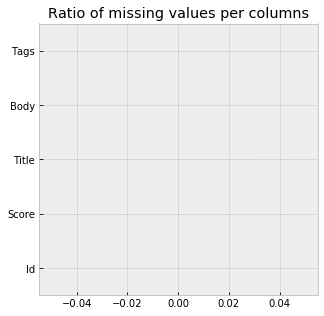

In [20]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [21]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [22]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [23]:
# new_df.head(5)

In [24]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [25]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [26]:
len(all_tags)

224129

In [27]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [28]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [29]:
# tags_features

In [30]:
# fig, ax = plt.subplots(figsize=(15, 10))
# keywords.plot(100, cumulative=False)

In [31]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [32]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [33]:
new_df.shape

(72950, 3)

In [34]:
new_df.dropna(subset=['Tags'], inplace=True)

In [35]:
new_df.shape

(63167, 3)

We are here loosing 10000 rows but the it's for the greater good. 

**1.2.2 Body**

In the next two columns: Body and Title, I'll use lots of text processing:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [36]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [37]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [38]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [39]:
token=ToktokTokenizer()

In [40]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [42]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [43]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [44]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [45]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [46]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guoya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Guoya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [48]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [49]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [50]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

**1.3 EDA**

Here I'll just use some LDA to see if shows any paterns in words and the main topics.  

In [51]:
no_topics = 20

In [52]:
text = new_df['Body']

In [53]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [54]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [55]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [56]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
# display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

It's a bit disappointing but I'm certain that it can be done better. 

**PART 2: Classical classifiers**

**2.1 Data preparation**

Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [57]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']


# save original data as raw
df_raw = new_df
X1_raw = X1
X2_raw = X2
y_raw = y

In [58]:
print(X1.shape)
print(X1[1])

(63167,)
really good tutorials explain branch merge apache subversion better specific tortoisesvn client


In [59]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)
print(y_bin)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [60]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [61]:
print('X1.SHAPE', X1.shape)
print('X2.SHAPE', X2.shape)

X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

print('X1_tfidf.SHAPE', X1_tfidf.shape)
print('X2_tfidf.SHAPE', X2_tfidf.shape)

X1.SHAPE (63167,)
X2.SHAPE (63167,)
X1_tfidf.SHAPE (63167, 1000)
X2_tfidf.SHAPE (63167, 1000)


In [62]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

Now it's finally ready. 

In [64]:
# test========================================================================================================================================
import scipy

# print(X_train[0])
print('X_train.shape', X_train.shape)
print('**************************')
print('y_train.shape', y_train.shape)
# print(y_train[0])


# from sparse to full
X_train_sc = scipy.sparse.csr_matrix(X_train)
X_train_np = X_train_sc.A
X_train_np = X_train_np.astype(float)

y_train_sc = scipy.sparse.csr_matrix(y_train)
y_train_np = y_train_sc.A
y_train_np = y_train_np.astype(float)

X_test_sc = scipy.sparse.csr_matrix(X_test)
X_test_np = X_test_sc.A
X_test_np = X_test_np.astype(float)

y_test_sc = scipy.sparse.csr_matrix(y_test)
y_test_np = y_test_sc.A
y_test_np = y_test_np.astype(float)

X_train.shape (50533, 2000)
**************************
y_train.shape (50533, 100)


In [121]:
# check raw data
print(len(X1_raw))  #63167
print(len(X2_raw))  #63167
print(len(y_raw))  #63167
print(type(X1_raw))
print(type(X2_raw))
print(type(y_raw))
# print(X1_raw[110])
print('================================================')
# print(X1_raw)
print(y_raw)

# null check
print(X1_raw.isnull().values.any())
print(X2_raw.isnull().values.any())
print(y_raw.isnull().values.any())

# for i, ele in enumerate(X1_raw):
#     if i>63000:
#         print(i)
#         print(ele)
#         print('***********************************')
#     if pd.isnull(ele):
#         print(i)

63167
63167
63167
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
1                                [svn]
2                       [sql, asp.net]
3                          [algorithm]
4                           [c#, .net]
5                    [c++, oop, class]
6                               [.net]
7                         [sql-server]
8                  [c#, visual-studio]
9             [windows, visual-studio]
10                      [c#, database]
11                       [c#, asp.net]
12                                [c#]
14                               [svn]
16                              [.net]
17                        [sql-server]
18                        [sql-server]
19                        [sql-server]
20            [c#, .net, unit-testing]
21                               [svn]
22         [sql, database, postgresql]
23                   [sql, sql-server]
24                                [c#]
26              

### torchtext embedding

In [125]:
import torchtext as tt
# import spacy
# spacy_en = spacy.load('en')
TEXT = tt.data.Field(tokenize='spacy')
TEXT.build_vocab(X1_raw, max_size=10000, vectors='glove.6B.100d')

print(TEXT)
print(type(TEXT))
print(TEXT.preprocess(100))

<class 'torchtext.data.field.Field'>
100
